# SMAI 

## Assignmnet 4

### Question 1
### Ensemble Learning: Classification

In this question of the assignment, we will be implementing bagging using 3 different base models. Let us begin by visualising the data fo th classification task which is the Wine Quality Dataset.

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, r2_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from scipy import stats

In [42]:
data1 = pd.read_csv('WineQT.csv')
data1 = data1.drop('Id', 1)
print(data1.head())
print(data1['quality'].unique())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

/tmp/ipykernel_14153/231220394.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data1 = data1.drop('Id', 1)


In [43]:
feature_columns = data1.columns.tolist()

imputer = SimpleImputer(strategy='mean')
data = pd.DataFrame(imputer.fit_transform(data1), columns=data1.columns)

scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data[feature_columns[:-1]]), columns=feature_columns[:-1])
data = pd.concat([data, data1['quality']], axis = 1)

Train_df, rest_df = train_test_split(data, test_size=0.3)
Test_df, Val_df = train_test_split(rest_df, test_size=0.2/0.3)


X_train = Train_df[feature_columns[:-1]].to_numpy()
X_val = Val_df[feature_columns[:-1]].to_numpy()
X_test = Test_df[feature_columns[:-1]].to_numpy()

Y_train = Train_df[feature_columns[-1]].to_numpy() - 3
Y_val = Val_df[feature_columns[-1]].to_numpy() - 3
Y_test = Test_df[feature_columns[-1]].to_numpy() - 3

Y_train_oh = np.eye(6)[Y_train].T
Y_val_oh = np.eye(6)[Y_val].T
Y_test_oh = np.eye(6)[Y_test].T

Let us now create a class which will be used as the base models for our bagging implementation.

In [44]:
class TreeClassifier:

    def __init__(self):
        self.model = DecisionTreeClassifier()
        self.name = 'Decision Tree'

    def fit(self, X, y):
        y = np.argmax(y, 0)
        return self.model.fit(X, y)

    def predict(self, X):
        predictions = self.model.predict_proba(X)
        while predictions.shape[1] < 6:
            pad = np.zeros((predictions.shape[0], 1))
            predictions = np.concatenate((predictions, pad), axis = 1)

        return predictions.T

class MultiLogistic:

    def __init__(self):
        self.params = {'W': None, 'b': None}
        self.gradients = {'dW': None, 'db': None}
        self.name = 'Logistic Regression'

    def softmax(self, x):
        return np.exp(x)/np.sum(np.exp(x), axis = 0, keepdims=True)

    def initialisation(self, n_input, n_output):
        self.params['W'] = np.random.rand(n_output, n_input)
        self.params['b'] = np.zeros((n_output, 1))

    def forward_prop(self, input):
        Z = np.dot(self.params['W'], input.T) + self.params['b']
        A = self.softmax(Z)

        return A

    def loss(self, A, Y):
        m = Y.shape[1]
        return -np.sum(np.log(A)*Y)/m

    def backprop(self, A, X, Y):
        m = X.shape[0]

        dZ = A - Y
        self.gradients['dW'] = np.dot(dZ, X)/m
        self.gradients['db'] = np.sum(dZ, axis = 1, keepdims=True)/m

    def optimization(self, lr):
        self.params['W'] -= lr*self.gradients['dW']
        self.params['b'] -= lr*self.gradients['db']
    
    def fit(self, X_train, Y_train_oh, num_classes = 6, num_epochs = 1000, learning_rate = 0.05):
        input_size = X_train.shape[1]
        self.initialisation(input_size, num_classes)

        for epoch in range(num_epochs):
            Y_pred_train = self.forward_prop(X_train)
            
            Loss_train = self.loss(Y_pred_train, Y_train_oh)

            self.backprop(Y_pred_train, X_train, Y_train_oh)

            self.optimization(learning_rate)

    def predict(self, X):
        return self.forward_prop(X)


class MLP:

    def __init__(self, lr = 0.01, activation = None, der_activation = None, optimiser = None, hidden_layers = None):
        self.lr = 0.01
        self.activation = [self.relu, self.relu, self.relu, self.softmax]
        self.optim = self.gradient_descent
        self.hidden = [32, 16, 10]
        self.der_activation = [self.der_relu, self.der_relu, self.der_relu]
        self.name = 'Multi Layer Perceptron'

    def set_der_activation(self, der_activation):
        self.der_activation = der_activation

    def set_lr(self, lr):
        self.lr = lr

    def set_activation(self, activation):
        self.activation = activation

    def set_optimiser(self, optimiser):
        self.optim = optimiser
    
    def set_hidden(self, hidden):
        self.hidden = hidden

    def sigmoid(self, x):
        return 1/(1 + np.exp(-x))

    def relu(self, x):
        return np.maximum(0, x)
    
    def tanh(self, x):
        return np.tanh(x)

    def softmax(self, x):
        x_max = np.max(x, axis = 0, keepdims=True)
        return np.exp(x - x_max)/np.sum(np.exp(x - x_max), axis = 0, keepdims=True)

    def der_tanh(self, x):
        return 1 - (np.tanh(x)**2)

    def der_relu(self, x):
        return np.where(x > 0, 1, 0)

    def der_sigmoid(self, x):
        return self.sigmoid(x)*(1 - self.sigmoid(x))

    def initialisation(self, input_size, output_size):
        self.params = {}

        self.params['W1'] = np.random.rand(self.hidden[0], input_size)
        self.params['b1'] = np.zeros((self.hidden[0], 1))
        i = 0
        for i in range(1, len(self.hidden)):
            self.params['W'+str(i+1)] = np.random.rand(self.hidden[i], self.hidden[i-1])
            self.params['b'+str(i+1)] = np.zeros((self.hidden[i], 1))
        
        self.params['W'+str(i+2)] = np.random.rand(output_size, self.hidden[-1])
        self.params['b'+str(i+2)] = np.zeros((output_size, 1))

    def forward_prop(self, input):
        cache = {}

        cache['Z1'] = np.dot(self.params['W1'], input.T) + self.params['b1']
        cache['A1'] = self.activation[0](cache['Z1'])

        for i in range(1, len(self.activation)):
            cache['Z'+str(i+1)] = np.dot(self.params['W'+str(i+1)], cache['A'+str(i)]) + self.params['b'+str(i+1)]
            cache['A'+str(i+1)] = self.activation[i](cache['Z'+str(i+1)])

        return cache['A'+str(len(self.activation))], cache

    def loss(self, A, Y):
        m = Y.shape[1]
        return -np.sum(np.log(A + 1e-10)*Y)/m

    def backward_prop(self, cache, X, Y):
        m = X.shape[0]
        self.gradients = {}

        dZ = cache['A'+str(len(self.activation))] - Y
        for i in range(len(self.activation) - 1, 0, -1):
            self.gradients['dW'+str(i+1)] = np.dot(dZ, cache['A' + str(i)].T)/m
            self.gradients['db'+str(i+1)] = np.sum(dZ, axis = 1, keepdims=True)/m
            dZ = np.dot(self.params['W'+str(i+1)].T, dZ) * self.der_activation[i - 1](cache['Z'+str(i)])

        self.gradients['dW1'] = np.dot(dZ, X)/m
        self.gradients['db1'] = np.sum(dZ, axis = 1, keepdims=True)/m 

    def optimisation(self):
        for i in range(len(self.activation)):
            self.params['W'+str(i+1)] -= self.lr*self.gradients['dW'+str(i+1)]
            self.params['b'+str(i+1)] -= self.lr*self.gradients['db'+str(i+1)]

    def gradient_descent(self, X_train, Y_train_oh, num_epochs, input_size, output_size):
        self.initialisation(input_size, output_size)

        for epoch in range(num_epochs):
            Y_pred_train, train_cache = self.forward_prop(X_train)
      
            Loss_train = self.loss(Y_pred_train, Y_train_oh)

            self.backward_prop(train_cache, X_train, Y_train_oh)

            self.optimisation()



    def fit(self, X_train, Y_train_oh, num_epochs = 100, input_size = 11, output_size = 6):
        return self.optim(X_train, Y_train_oh, num_epochs, input_size, output_size)

    def predict(self, X):
        output, _ = self.forward_prop(X)
        return output

Now let us make the function which will implement the bagging methodology

In [45]:
def bagging_ensemble(X, y, base_estimator, n_estimators, sample_fraction, bootstrap, voting):
    ensemble_models = []

    for _ in range(n_estimators):
        
        indicies = np.random.choice(len(X), int(len(X)*sample_fraction), replace = bootstrap)

        X_train = X[indicies]
        y_train = y[:, indicies]
        

        base_model = base_estimator()
        base_model.fit(X_train, y_train)
        ensemble_models.append(base_model)

    

    def ensemble_predict(X):
        predictions = [model.predict(X).T for model in ensemble_models]
        predictions = np.array(predictions)
        
        if voting == 'hard':
            predictions = np.argmax(predictions, axis = 2)
            return stats.mode(predictions, keepdims = False)[0]
        else:
            predictions = np.mean(predictions, axis = 0)
            return np.argmax(predictions, axis = 1)

    y_pred = ensemble_predict(X)
    y = np.argmax(y, 0)
    accuracy = (y_pred == y).mean()

    return ensemble_models, accuracy

def ensemble_predict(X, ensemble_models, voting):

        predictions = [model.predict(X).T for model in ensemble_models]
        predictions = np.array(predictions)
        if voting == 'hard':
            predictions = np.argmax(predictions, axis = 2)
            return stats.mode(predictions, keepdims = False)[0]
        else:
            predictions = np.mean(predictions, axis = 0)
            return np.argmax(predictions, axis = 1)


Now, let us train ensemble models for all different combination of parameters above.

In [46]:
base_estimators = [TreeClassifier, MultiLogistic, MLP]
votings = ['hard', 'soft']
bootstraps = [True, False]
sample_fractions = [0.15, 0.25, 0.5, 0.75, 1.0]
n_estimators = [5, 10, 15]



for base_estimator in base_estimators:
    for voting in votings:
        for bootstrap in bootstraps:
            for sample_fraction in sample_fractions:
                for n_estimator in n_estimators:
                    model = base_estimator()
                    ensemble_models, train_accuracy = bagging_ensemble(X_train, Y_train_oh, base_estimator, n_estimator, sample_fraction, bootstrap, voting)
                    y_pred = ensemble_predict(X_val, ensemble_models, voting)
                    val_accuracy = (y_pred == Y_val).mean()
                    print('----------------')
                    print(f'BASE ESTIMATOR: {model.name}')
                    print(f'NUMBER OF ESTIMATORs: {n_estimator}')
                    print(f'SAMPLE FRACTIONS: {sample_fraction}')
                    print(f'BOOTSTRAP: {bootstrap}')
                    print(f'VOTING: {voting}')
                    print(f'TRAIN ACCURACY: {train_accuracy}, VALIDATION ACCURACY: {val_accuracy}')

----------------
BASE ESTIMATOR: Decision Tree
NUMBER OF ESTIMATORs: 5
SAMPLE FRACTIONS: 0.15
BOOTSTRAP: True
VOTING: hard
TRAIN ACCURACY: 0.5725, VALIDATION ACCURACY: 0.5109170305676856
----------------
BASE ESTIMATOR: Decision Tree
NUMBER OF ESTIMATORs: 10
SAMPLE FRACTIONS: 0.15
BOOTSTRAP: True
VOTING: hard
TRAIN ACCURACY: 0.135, VALIDATION ACCURACY: 0.2052401746724891
----------------
BASE ESTIMATOR: Decision Tree
NUMBER OF ESTIMATORs: 15
SAMPLE FRACTIONS: 0.15
BOOTSTRAP: True
VOTING: hard
TRAIN ACCURACY: 0.23875, VALIDATION ACCURACY: 0.2794759825327511
----------------
BASE ESTIMATOR: Decision Tree
NUMBER OF ESTIMATORs: 5
SAMPLE FRACTIONS: 0.25
BOOTSTRAP: True
VOTING: hard
TRAIN ACCURACY: 0.1125, VALIDATION ACCURACY: 0.1615720524017467
----------------
BASE ESTIMATOR: Decision Tree
NUMBER OF ESTIMATORs: 10
SAMPLE FRACTIONS: 0.25
BOOTSTRAP: True
VOTING: hard
TRAIN ACCURACY: 0.68375, VALIDATION ACCURACY: 0.5109170305676856
----------------
BASE ESTIMATOR: Decision Tree
NUMBER OF ESTI

In [47]:
base_estimator = TreeClassifier
n_estimator = 5
sample_fraction = 1.0
bootstrap = False
voting = 'soft'

ensemble_models, train_accuracy = bagging_ensemble(X_train, Y_train_oh, base_estimator, n_estimator, sample_fraction, bootstrap, voting)
y_pred = ensemble_predict(X_test, ensemble_models, voting)
val_accuracy = (y_pred == Y_test).mean()
print(f'TEST ACCURACY: {val_accuracy}')

TEST ACCURACY: 0.5614035087719298


As we can see, the validation accuracies ae much more higher when we use Decision Trees. At the same time, it is better to use large number of estimators as well as use hard voting.

Now let us plot a heatmap for the accuracies obtained by each class of base estimator models across Fraction of Samples and Number of Estimators.

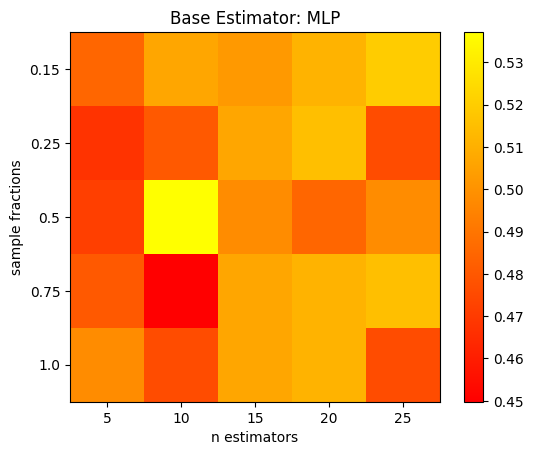

In [48]:
base_estimator = MLP
bootstrap = True
voting = 'hard'
sample_fractions = [0.15, 0.25, 0.5, 0.75, 1.0]
n_estimators = [5, 10, 15, 20, 25]

Accuracies = np.zeros((5, 5))

for i, sample_fraction in enumerate(sample_fractions):
    for j, n_estimator in enumerate(n_estimators):
        model = base_estimator()
        ensemble_models, train_accuracy = bagging_ensemble(X_train, Y_train_oh, base_estimator, n_estimator, sample_fraction, bootstrap, voting)
        y_pred = ensemble_predict(X_val, ensemble_models, voting)
        val_accuracy = (y_pred == Y_val).mean()
        Accuracies[i, j] = val_accuracy
        
plt.imshow(Accuracies, cmap='autumn')
plt.colorbar()
plt.title('Base Estimator: MLP')
plt.xlabel('n estimators')
plt.ylabel('sample fractions')
plt.xticks(range(len(n_estimators)), n_estimators)
plt.yticks(range(len(sample_fractions)), sample_fractions)
plt.show()

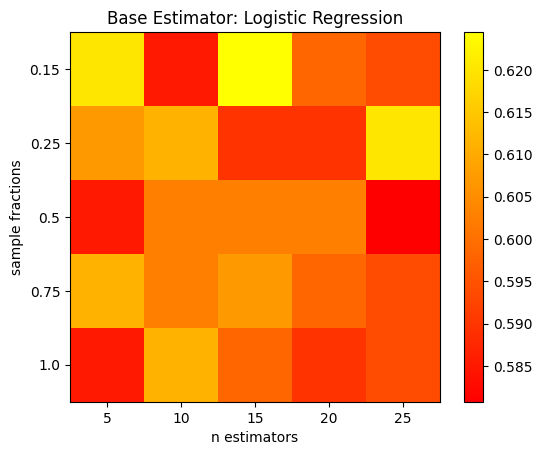

In [49]:
base_estimator = MultiLogistic
bootstrap = True
voting = 'hard'
sample_fractions = [0.15, 0.25, 0.5, 0.75, 1.0]
n_estimators = [5, 10, 15, 20, 25]

Accuracies = np.zeros((5, 5))

for i, sample_fraction in enumerate(sample_fractions):
    for j, n_estimator in enumerate(n_estimators):
        model = base_estimator()
        ensemble_models, train_accuracy = bagging_ensemble(X_train, Y_train_oh, base_estimator, n_estimator, sample_fraction, bootstrap, voting)
        y_pred = ensemble_predict(X_val, ensemble_models, voting)
        val_accuracy = (y_pred == Y_val).mean()
        Accuracies[i, j] = val_accuracy
        
plt.imshow(Accuracies, cmap='autumn')
plt.colorbar()
plt.title('Base Estimator: Logistic Regression')
plt.xlabel('n estimators')
plt.ylabel('sample fractions')
plt.xticks(range(len(n_estimators)), n_estimators)
plt.yticks(range(len(sample_fractions)), sample_fractions)
plt.show()

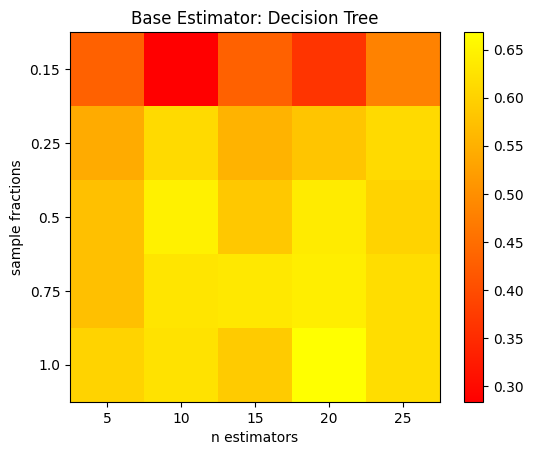

In [50]:
base_estimator = TreeClassifier
bootstrap = True
voting = 'hard'
sample_fractions = [0.15, 0.25, 0.5, 0.75, 1.0]
n_estimators = [5, 10, 15, 20, 25]

Accuracies = np.zeros((5, 5))

for i, sample_fraction in enumerate(sample_fractions):
    for j, n_estimator in enumerate(n_estimators):
        model = base_estimator()
        ensemble_models, train_accuracy = bagging_ensemble(X_train, Y_train_oh, base_estimator, n_estimator, sample_fraction, bootstrap, voting)
        y_pred = ensemble_predict(X_val, ensemble_models, voting)
        val_accuracy = (y_pred == Y_val).mean()
        Accuracies[i, j] = val_accuracy
        
plt.imshow(Accuracies, cmap='autumn')
plt.colorbar()
plt.title('Base Estimator: Decision Tree')
plt.xlabel('n estimators')
plt.ylabel('sample fractions')
plt.xticks(range(len(n_estimators)), n_estimators)
plt.yticks(range(len(sample_fractions)), sample_fractions)
plt.show()

Now let us compare the performance of the individual models along with the ensmable models for each base classifier.

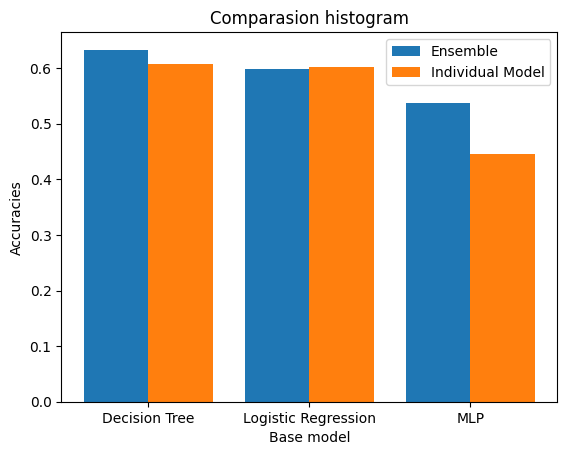

In [51]:
base_estimators = [TreeClassifier, MultiLogistic, MLP]
bootstrap = False
voting = 'soft'
n_estimator = 15
sample_fraction = 0.5
ensemble_accuracies = []

for base_estimator in base_estimators:
    model = base_estimator()
    ensemble_models, train_accuracy = bagging_ensemble(X_train, Y_train_oh, base_estimator, n_estimator, sample_fraction, bootstrap, voting)
    y_pred = ensemble_predict(X_val, ensemble_models, voting)
    val_accuracy = (y_pred == Y_val).mean()
    ensemble_accuracies.append(val_accuracy)

base_estimators = [TreeClassifier, MultiLogistic, MLP]
bootstrap = False
voting = 'hard'
n_estimator = 1
sample_fraction = 1.0
model_accuracies = []

for base_estimator in base_estimators:
    model = base_estimator()
    ensemble_models, train_accuracy = bagging_ensemble(X_train, Y_train_oh, base_estimator, n_estimator, sample_fraction, bootstrap, voting)
    y_pred = ensemble_predict(X_val, ensemble_models, voting)
    val_accuracy = (y_pred == Y_val).mean()
    model_accuracies.append(val_accuracy)

models = ['Decision Tree', 'Logistic Regression', 'MLP']
X_axis = np.arange(len(model_accuracies)) 
  
plt.bar(X_axis - 0.2, ensemble_accuracies, 0.4, label = 'Ensemble') 
plt.bar(X_axis + 0.2, model_accuracies, 0.4, label = 'Individual Model')
plt.xticks(X_axis, models)
plt.title('Comparasion histogram')
plt.xlabel('Base model')
plt.ylabel('Accuracies')
plt.legend()
plt.show()

Here we can see, that the ensemble does better than the individual models most of the times

Now let us implement the same thing for for a regression problem. For this, we will be using the Boston Housing Dataset. Let us laod and have a look at the dataset.

In [52]:
housing_data = pd.read_csv('HousingData.csv')
print(housing_data.head())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90    NaN  36.2  


In [53]:
feature_columns = housing_data.columns.tolist()

imputer = SimpleImputer(strategy='mean')
data_housing = pd.DataFrame(imputer.fit_transform(housing_data), columns=housing_data.columns)

scaler = StandardScaler()
data_housing = pd.DataFrame(scaler.fit_transform(data_housing[feature_columns[:-1]]), columns=feature_columns[:-1])
data_housing = pd.concat([data_housing, housing_data['MEDV']], axis = 1)

Train_df, rest_df = train_test_split(data_housing, test_size=0.3)
Test_df, Val_df = train_test_split(rest_df, test_size=0.2/0.3)


X_train = Train_df[feature_columns[:-1]].to_numpy()
X_val = Val_df[feature_columns[:-1]].to_numpy()
X_test = Test_df[feature_columns[:-1]].to_numpy()

Y_train = Train_df[feature_columns[-1]].to_numpy()
Y_val = Val_df[feature_columns[-1]].to_numpy()
Y_test = Test_df[feature_columns[-1]].to_numpy()


Let us now create a class which will be used as the base models for our bagging implementation.

In [54]:
class TreeRegressor:

    def __init__(self):
        self.model = DecisionTreeRegressor()
        self.name = 'Decision Tree'

    def fit(self, X, y):
        return self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

class LinearRegression:

    def __init__(self):
        self.params = {'W': None, 'b': None}
        self.gradients = {'dW': None, 'db': None}
        self.name = 'Linear Regression'

    def softmax(self, x):
        return np.exp(x)/np.sum(np.exp(x), axis = 0, keepdims=True)

    def initialisation(self, n_input, n_output):
        self.params['W'] = np.random.rand(n_output, n_input)
        self.params['b'] = np.zeros((n_output, 1))

    def forward_prop(self, input):
        A = np.dot(self.params['W'], input.T) + self.params['b']

        return A

    def loss(self, A, Y):
        m = Y.shape[1]
        return -np.sum(np.log(A)*Y)/m

    def backprop(self, A, X, Y):
        m = X.shape[0]

        dZ = (A - Y)*2
        self.gradients['dW'] = np.dot(dZ, X)/m
        self.gradients['db'] = np.sum(dZ, axis = 1, keepdims=True)/m

    def optimization(self, lr):
        self.params['W'] -= lr*self.gradients['dW']
        self.params['b'] -= lr*self.gradients['db']
    
    def fit(self, X_train, Y_train_oh, num_classes = 1, num_epochs = 1000, learning_rate = 0.05):
        input_size = X_train.shape[1]
        self.initialisation(input_size, num_classes)

        for epoch in range(num_epochs):
            Y_pred_train = self.forward_prop(X_train)

            self.backprop(Y_pred_train, X_train, Y_train_oh)

            self.optimization(learning_rate)

    def predict(self, X):
        return self.forward_prop(X)

class MLP_regression:

    def __init__(self, lr = 0.0, activation = None, der_activation = None, optimiser = None, hidden_layers = None):
        self.lr = 0.01
        self.activation = [self.relu, self.relu, self.relu, self.linear]
        self.optim = self.gradient_descent
        self.hidden = [32, 16, 10]
        self.der_activation = [self.der_relu, self.der_relu, self.der_relu]
        self.name = 'MLP Regression'

    def set_der_activation(self, der_activation):
        self.der_activation = der_activation

    def set_lr(self, lr):
        self.lr = lr

    def set_activation(self, activation):
        self.activation = activation

    def set_optimiser(self, optimiser):
        self.optim = optimiser
    
    def set_hidden(self, hidden):
        self.hidden = hidden

    def sigmoid(self, x):
        return 1/(1 + np.exp(-x))

    def relu(self, x):
        return np.maximum(0, x)
    
    def tanh(self, x):
        return np.tanh(x)

    def linear(self, x):
        return x

    def der_tanh(self, x):
        return 1 - (np.tanh(x)**2)

    def der_relu(self, x):
        return np.where(x > 0, 1, 0)

    def der_sigmoid(self, x):
        return self.sigmoid(x)*(1 - self.sigmoid(x))

    def initialisation(self, input_size, output_size):
        self.params = {}

        self.params['W1'] = np.random.rand(self.hidden[0], input_size)
        self.params['b1'] = np.zeros((self.hidden[0], 1))
        i = 0
        for i in range(1, len(self.hidden)):
            self.params['W'+str(i+1)] = np.random.rand(self.hidden[i], self.hidden[i-1])
            self.params['b'+str(i+1)] = np.zeros((self.hidden[i], 1))
        
        self.params['W'+str(i+2)] = np.random.rand(output_size, self.hidden[-1])
        self.params['b'+str(i+2)] = np.zeros((output_size, 1))

    def forward_prop(self, input):
        cache = {}

        cache['Z1'] = np.dot(self.params['W1'], input.T) + self.params['b1']
        cache['A1'] = self.activation[0](cache['Z1'])

        for i in range(1, len(self.activation)):
            cache['Z'+str(i+1)] = np.dot(self.params['W'+str(i+1)], cache['A'+str(i)]) + self.params['b'+str(i+1)]
            cache['A'+str(i+1)] = self.activation[i](cache['Z'+str(i+1)])

        return cache['A'+str(len(self.activation))], cache

    def loss(self, A, Y):
        m = Y.shape[0]
        return np.sum((np.squeeze(A) -Y)**2)/m

    def backward_prop(self, cache, X, Y):
        m = X.shape[0]
        self.gradients = {}

        dZ = (cache['A'+str(len(self.activation))] - Y)*2
        for i in range(len(self.activation) - 1, 0, -1):
            self.gradients['dW'+str(i+1)] = np.dot(dZ, cache['A' + str(i)].T)/m
            self.gradients['db'+str(i+1)] = np.sum(dZ, axis = 1, keepdims=True)/m
            dZ = np.dot(self.params['W'+str(i+1)].T, dZ) * self.der_activation[i - 1](cache['Z'+str(i)])

        self.gradients['dW1'] = np.dot(dZ, X)/m
        self.gradients['db1'] = np.sum(dZ, axis = 1, keepdims=True)/m 

    def optimisation(self):
        for i in range(len(self.activation)):
            self.params['W'+str(i+1)] -= self.lr*self.gradients['dW'+str(i+1)]
            self.params['b'+str(i+1)] -= self.lr*self.gradients['db'+str(i+1)]

    def gradient_descent(self, X_train, Y_train, num_epochs, input_size, output_size):
        self.initialisation(input_size, output_size)

        for epoch in range(num_epochs):
            Y_pred_train, train_cache = self.forward_prop(X_train)
            
            Loss_train = self.loss(Y_pred_train, Y_train)

            self.backward_prop(train_cache, X_train, Y_train)

            self.optimisation()

    

    def fit(self, X_train, Y_train, num_epochs = 100, input_size = 13, output_size = 1):
        return self.optim(X_train, Y_train, num_epochs, input_size, output_size)

    def predict(self, X):
        output, _ = self.forward_prop(X)
        return output


Now let us implement the function for bagging in regression.

In [55]:
def bagging_ensemble(X, y, base_estimator, n_estimators, sample_fraction, bootstrap, voting):
    ensemble_models = []

    for _ in range(n_estimators):
        
        indicies = np.random.choice(len(X), int(len(X)*sample_fraction), replace = bootstrap)

        X_train = X[indicies]
        y_train = y[indicies]
        

        base_model = base_estimator()
        base_model.fit(X_train, y_train)
        ensemble_models.append(base_model)

    

    def ensemble_predict(X):
        predictions = [np.squeeze(model.predict(X)) for model in ensemble_models]
        predictions = np.array(predictions)
        
        if voting == 'hard':
            predictions = np.mean(predictions, axis = 0)
            return predictions
        else:
            val_predictions = [np.squeeze(model.predict(X_val)) for model in ensemble_models]
            val_predictions = np.array(val_predictions)
            val_loss = np.reciprocal(np.array([mean_squared_error(Y_val, x) for x in val_predictions]))
            predictions = np.sum(predictions*val_loss[:, np.newaxis], axis = 0)/np.sum(val_loss)
            return predictions
            


    y_pred = ensemble_predict(X)
    accuracy = mean_squared_error(y_pred, y)

    return ensemble_models, accuracy

def ensemble_predict(X, ensemble_models, voting):

        predictions = [np.squeeze(model.predict(X)) for model in ensemble_models]
        predictions = np.array(predictions)
        
        if voting == 'hard':
            predictions = np.mean(predictions, axis = 0)
            return predictions
        else:
            val_predictions = [np.squeeze(model.predict(X_val)) for model in ensemble_models]
            val_predictions = np.array(val_predictions)
            val_loss = np.reciprocal(np.array([mean_squared_error(Y_val, x) for x in val_predictions]))
            predictions = np.sum(predictions*val_loss[:, np.newaxis], axis = 0)/np.sum(val_loss)
            return predictions


In [56]:
base_estimators = [TreeRegressor, LinearRegression, MLP_regression]
votings = ['hard', 'soft']
bootstraps = [True, False]
sample_fractions = [0.15, 0.25, 0.5, 0.75, 1.0]
n_estimators = [5, 10, 15]



for base_estimator in base_estimators:
    for voting in votings:
        for bootstrap in bootstraps:
            for sample_fraction in sample_fractions:
                for n_estimator in n_estimators:
                    model = base_estimator()
                    ensemble_models, train_accuracy = bagging_ensemble(X_train, Y_train, base_estimator, n_estimator, sample_fraction, bootstrap, voting)
                    y_pred = ensemble_predict(X_val, ensemble_models, voting)
                    r2 = r2_score(y_pred, Y_val)
                    val_accuracy = mean_squared_error(y_pred, Y_val)
                    print('----------------')
                    print(f'BASE ESTIMATOR: {model.name}')
                    print(f'NUMBER OF ESTIMATORs: {n_estimator}')
                    print(f'SAMPLE FRACTIONS: {sample_fraction}')
                    print(f'BOOTSTRAP: {bootstrap}')
                    print(f'VOTING: {voting}')
                    print(f'TRAIN MSE Loss: {train_accuracy}, VALIDATION MSE Loss: {val_accuracy}')
                    print(f'R2 SCORE: {r2}')

----------------
BASE ESTIMATOR: Decision Tree
NUMBER OF ESTIMATORs: 5
SAMPLE FRACTIONS: 0.15
BOOTSTRAP: True
VOTING: hard
TRAIN MSE Loss: 18.42270508474576, VALIDATION MSE Loss: 13.601749019607846
R2 SCORE: 0.7677055371009938
----------------
BASE ESTIMATOR: Decision Tree
NUMBER OF ESTIMATORs: 10
SAMPLE FRACTIONS: 0.15
BOOTSTRAP: True
VOTING: hard
TRAIN MSE Loss: 15.30040649717514, VALIDATION MSE Loss: 15.642569607843136
R2 SCORE: 0.6800820654923193
----------------
BASE ESTIMATOR: Decision Tree
NUMBER OF ESTIMATORs: 15
SAMPLE FRACTIONS: 0.15
BOOTSTRAP: True
VOTING: hard
TRAIN MSE Loss: 16.393753546767112, VALIDATION MSE Loss: 13.176225272331155
R2 SCORE: 0.7654808905436539
----------------
BASE ESTIMATOR: Decision Tree
NUMBER OF ESTIMATORs: 5
SAMPLE FRACTIONS: 0.25
BOOTSTRAP: True
VOTING: hard
TRAIN MSE Loss: 13.466682485875705, VALIDATION MSE Loss: 15.378258823529409
R2 SCORE: 0.7322434136620161
----------------
BASE ESTIMATOR: Decision Tree
NUMBER OF ESTIMATORs: 10
SAMPLE FRACTIONS

In [57]:
base_estimator = TreeRegressor
n_estimator = 15
sample_fraction = 0.25
bootstrap = False
voting = 'soft'

ensemble_models, train_accuracy = bagging_ensemble(X_train, Y_train, base_estimator, n_estimator, sample_fraction, bootstrap, voting)
y_pred = ensemble_predict(X_test, ensemble_models, voting)
val_accuracy = mean_squared_error(y_pred, Y_test)
r2 = r2_score(y_pred, Y_test)
print(f'TEST MSE LOSS: {val_accuracy}')
print(f'R2 SCORE: {r2}')

TEST MSE LOSS: 17.784859304715084
R2 SCORE: 0.722291534029761


Now let us plot the heat maps.

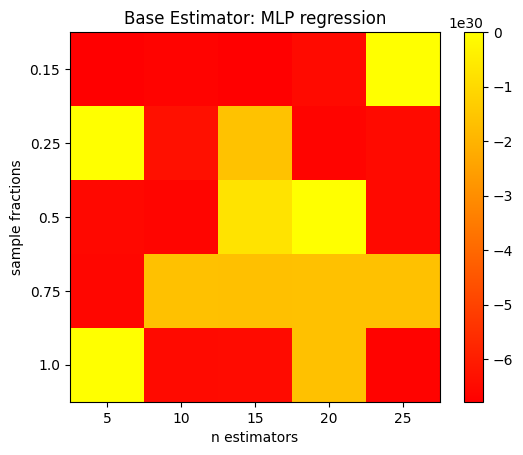

In [58]:
base_estimator = MLP_regression
bootstrap = True
voting = 'hard'
sample_fractions = [0.15, 0.25, 0.5, 0.75, 1.0]
n_estimators = [5, 10, 15, 20, 25]

Accuracies = np.zeros((5, 5))

for i, sample_fraction in enumerate(sample_fractions):
    for j, n_estimator in enumerate(n_estimators):
        model = base_estimator()
        ensemble_models, train_accuracy = bagging_ensemble(X_train, Y_train, base_estimator, n_estimator, sample_fraction, bootstrap, voting)
        y_pred = ensemble_predict(X_val, ensemble_models, voting)
        val_accuracy = r2_score(y_pred, Y_val)
        Accuracies[i, j] = val_accuracy
        
plt.imshow(Accuracies, cmap='autumn')
plt.colorbar()
plt.title('Base Estimator: MLP regression')
plt.xlabel('n estimators')
plt.ylabel('sample fractions')
plt.xticks(range(len(n_estimators)), n_estimators)
plt.yticks(range(len(sample_fractions)), sample_fractions)
plt.show()

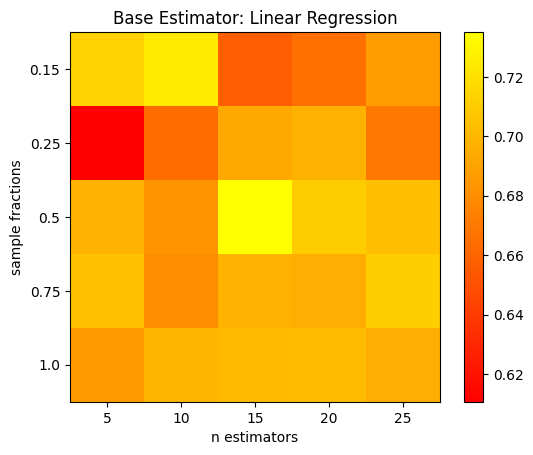

In [59]:
base_estimator = LinearRegression
bootstrap = True
voting = 'hard'
sample_fractions = [0.15, 0.25, 0.5, 0.75, 1.0]
n_estimators = [5, 10, 15, 20, 25]

Accuracies = np.zeros((5, 5))

for i, sample_fraction in enumerate(sample_fractions):
    for j, n_estimator in enumerate(n_estimators):
        model = base_estimator()
        ensemble_models, train_accuracy = bagging_ensemble(X_train, Y_train, base_estimator, n_estimator, sample_fraction, bootstrap, voting)
        y_pred = ensemble_predict(X_val, ensemble_models, voting)
        val_accuracy = r2_score(y_pred, Y_val)
        Accuracies[i, j] = val_accuracy
        
plt.imshow(Accuracies, cmap='autumn')
plt.colorbar()
plt.title('Base Estimator: Linear Regression')
plt.xlabel('n estimators')
plt.ylabel('sample fractions')
plt.xticks(range(len(n_estimators)), n_estimators)
plt.yticks(range(len(sample_fractions)), sample_fractions)
plt.show()

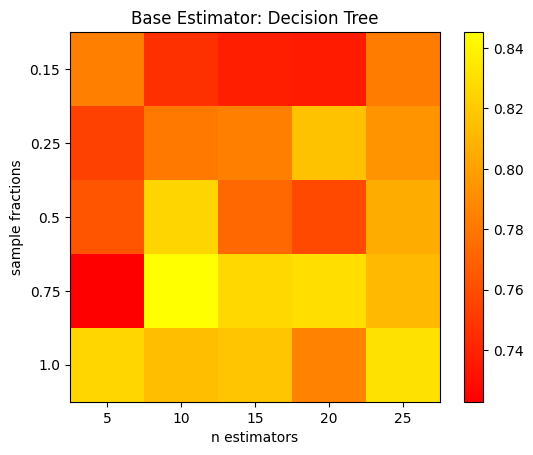

In [60]:
base_estimator = TreeRegressor
bootstrap = True
voting = 'hard'
sample_fractions = [0.15, 0.25, 0.5, 0.75, 1.0]
n_estimators = [5, 10, 15, 20, 25]

Accuracies = np.zeros((5, 5))

for i, sample_fraction in enumerate(sample_fractions):
    for j, n_estimator in enumerate(n_estimators):
        model = base_estimator()
        ensemble_models, train_accuracy = bagging_ensemble(X_train, Y_train, base_estimator, n_estimator, sample_fraction, bootstrap, voting)
        y_pred = ensemble_predict(X_val, ensemble_models, voting)
        val_accuracy = r2_score(y_pred, Y_val)
        Accuracies[i, j] = val_accuracy
        
plt.imshow(Accuracies, cmap='autumn')
plt.colorbar()
plt.title('Base Estimator: Decision Tree')
plt.xlabel('n estimators')
plt.ylabel('sample fractions')
plt.xticks(range(len(n_estimators)), n_estimators)
plt.yticks(range(len(sample_fractions)), sample_fractions)
plt.show()

Now let us compare the individual models

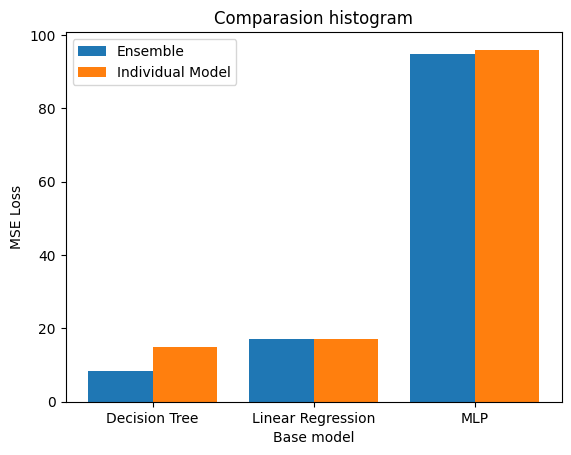

In [68]:
base_estimators = [TreeRegressor, LinearRegression, MLP_regression]
bootstrap = False
voting = 'soft'
n_estimator = 15
sample_fraction = 0.5
ensemble_accuracies = []

for base_estimator in base_estimators:
    model = base_estimator()
    ensemble_models, train_accuracy = bagging_ensemble(X_train, Y_train, base_estimator, n_estimator, sample_fraction, bootstrap, voting)
    y_pred = ensemble_predict(X_val, ensemble_models, voting)
    val_accuracy = mean_squared_error(y_pred, Y_val)
    ensemble_accuracies.append(val_accuracy)

base_estimators = [TreeRegressor, LinearRegression, MLP_regression]
bootstrap = False
voting = 'hard'
n_estimator = 1
sample_fraction = 1.0
model_accuracies = []

for base_estimator in base_estimators:
    model = base_estimator()
    ensemble_models, train_accuracy = bagging_ensemble(X_train, Y_train, base_estimator, n_estimator, sample_fraction, bootstrap, voting)
    y_pred = ensemble_predict(X_val, ensemble_models, voting)
    val_accuracy = mean_squared_error(y_pred, Y_val)
    model_accuracies.append(val_accuracy)

models = ['Decision Tree', 'Linear Regression', 'MLP']
X_axis = np.arange(len(model_accuracies)) 
  
plt.bar(X_axis - 0.2, ensemble_accuracies, 0.4, label = 'Ensemble') 
plt.bar(X_axis + 0.2, model_accuracies, 0.4, label = 'Individual Model')
plt.xticks(X_axis, models)
plt.title('Comparasion histogram')
plt.xlabel('Base model')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

Now we will implement the stacking implementation which is a technique used in ensemble learning. Following is the function used to implement the stacking methodology.

In [62]:
data1 = pd.read_csv('WineQT.csv')
data1 = data1.drop('Id', 1)

feature_columns = data1.columns.tolist()

imputer = SimpleImputer(strategy='mean')
data = pd.DataFrame(imputer.fit_transform(data1), columns=data1.columns)

scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data[feature_columns[:-1]]), columns=feature_columns[:-1])
data = pd.concat([data, data1['quality']], axis = 1)

Train_df, rest_df = train_test_split(data, test_size=0.3)
Test_df, Val_df = train_test_split(rest_df, test_size=0.2/0.3)


X_train = Train_df[feature_columns[:-1]].to_numpy()
X_val = Val_df[feature_columns[:-1]].to_numpy()
X_test = Test_df[feature_columns[:-1]].to_numpy()

Y_train = Train_df[feature_columns[-1]].to_numpy() - 3
Y_val = Val_df[feature_columns[-1]].to_numpy() - 3
Y_test = Test_df[feature_columns[-1]].to_numpy() - 3

Y_train_oh = np.eye(6)[Y_train].T
Y_val_oh = np.eye(6)[Y_val].T
Y_test_oh = np.eye(6)[Y_test].T


/tmp/ipykernel_14153/914245962.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data1 = data1.drop('Id', 1)


In [63]:
def stacking_blend(X_train, y_train, X_val, y_val, base_estimator, meta_estimator):
    
    ensemble_models = []

    for model in base_estimator:

        base_model = model()
        base_model.fit(X_train, y_train)
        ensemble_models.append(base_model)
    
    X_meta = np.zeros((len(base_estimator), len(X_val)))

    for i, model in enumerate(ensemble_models):
        predictions = model.predict(X_val).T
        predictions = np.argmax(predictions, axis = 1)

        X_meta[i] = predictions

    X_meta = X_meta.T

    meta_model = meta_estimator()

    meta_model.fit(X_meta, y_val)

    return ensemble_models, meta_model

def stacking_stacking(X_train, y_train, X_val, y_val, base_estimator, meta_estimator):
    X_train = np.concatenate((X_train, X_val), axis = 0)
    y_train = np.concatenate((y_train, y_val), axis = 1)
    k = 3
    k_fold = KFold(k, shuffle=True, random_state=101)

    ensemble_models = []
    for j, models in enumerate(base_estimator):
        for i, (train_idx, val_idx) in enumerate(k_fold.split(X_train)):
            X_train_k, X_val_k = X_train[train_idx], X_train[val_idx]
            y_train_k, y_val_k = y_train[:, train_idx], y_train[:, val_idx]

            model = models()

            model.fit(X_train_k, y_train_k)

            predictions = model.predict(X_val_k).T
            predictions = np.argmax(predictions, axis = 1)

            if i == 0:
                prev_predictions = predictions
                prev_y_val_k = y_val_k
            else:
                prev_predictions = np.concatenate((prev_predictions, predictions), axis = 0)
                prev_y_val_k = np.concatenate((prev_y_val_k, y_val_k), axis = 1)

        if j == 0:
            preds = prev_predictions[:, np.newaxis]
        else:
            preds = np.concatenate((preds, prev_predictions[:, np.newaxis]), axis = 1)

    meta_model = meta_estimator()
    meta_model.fit(preds, prev_y_val_k)

    for model in base_estimator:
        base_model = model()
        base_model.fit(X_train, y_train)
        ensemble_models.append(base_model)

    return ensemble_models, meta_model




def stacking(X_train, y_train, X_val, y_val, base_estimator, meta_estimator, method):
    if method == 'blending':
        return stacking_blend(X_train, y_train, X_val, y_val, base_estimator, meta_estimator)

    else:
        return stacking_stacking(X_train, y_train, X_val, y_val, base_estimator, meta_estimator)

def stacking_predict(X, ensemble_model, meta_model):

    X_meta = np.zeros((len(ensemble_model), len(X)))
    for i, model in enumerate(ensemble_model):
        predictions = model.predict(X).T
        predictions = np.argmax(predictions, axis = 1)

        X_meta[i] = predictions

    X_meta = X_meta.T

    predictions = meta_model.predict(X_meta).T


    predictions = np.argmax(predictions, axis = 1)
    
    return predictions
    

In [64]:
base_estimator = [TreeClassifier, MultiLogistic, MLP]
meta_estimators = [TreeClassifier, MultiLogistic]
methods = ['blending', 'stacking']


for meta_estimator in meta_estimators:
    for method in methods:
        model = meta_estimator()
        ensemble_models, meta_model = stacking(X_train, Y_train_oh, X_val, Y_val_oh, base_estimator, meta_estimator, method)
        predictions = stacking_predict(X_test, ensemble_models, meta_model)
        acc = (Y_test == predictions).mean()
        print('----------------')
        print(f'META ESTIMATOR: {model.name}')
        print(f'METHOD: {method}')
        print(f'TEST ACCURACY: {acc}')

----------------
META ESTIMATOR: Decision Tree
METHOD: blending
TEST ACCURACY: 0.17543859649122806
----------------
META ESTIMATOR: Decision Tree
METHOD: stacking
TEST ACCURACY: 0.6052631578947368
----------------
META ESTIMATOR: Logistic Regression
METHOD: blending
TEST ACCURACY: 0.6140350877192983
----------------
META ESTIMATOR: Logistic Regression
METHOD: stacking
TEST ACCURACY: 0.6228070175438597


The best model as we can see is if the meta estimator DecisionTree and we perform blending

Now let us do the same for regression

In [65]:
housing_data = pd.read_csv('HousingData.csv')

feature_columns = housing_data.columns.tolist()

imputer = SimpleImputer(strategy='mean')
data_housing = pd.DataFrame(imputer.fit_transform(housing_data), columns=housing_data.columns)

scaler = StandardScaler()
data_housing = pd.DataFrame(scaler.fit_transform(data_housing[feature_columns[:-1]]), columns=feature_columns[:-1])
data_housing = pd.concat([data_housing, housing_data['MEDV']], axis = 1)

Train_df, rest_df = train_test_split(data_housing, test_size=0.3)
Test_df, Val_df = train_test_split(rest_df, test_size=0.2/0.3)


X_train = Train_df[feature_columns[:-1]].to_numpy()
X_val = Val_df[feature_columns[:-1]].to_numpy()
X_test = Test_df[feature_columns[:-1]].to_numpy()

Y_train = Train_df[feature_columns[-1]].to_numpy()
Y_val = Val_df[feature_columns[-1]].to_numpy()
Y_test = Test_df[feature_columns[-1]].to_numpy()


In [66]:
def stacking_blend(X_train, y_train, X_val, y_val, base_estimator, meta_estimator):
    
    ensemble_models = []

    for model in base_estimator:

        base_model = model()
        base_model.fit(X_train, y_train)
        ensemble_models.append(base_model)
    
    X_meta = np.zeros((len(base_estimator), len(X_val)))

    for i, model in enumerate(ensemble_models):
        predictions = model.predict(X_val)
        X_meta[i] = predictions

    X_meta = X_meta.T
    X_meta /= np.sum(X_meta, axis = 1, keepdims=True)

    meta_model = meta_estimator()

    meta_model.fit(X_meta, y_val)

    return ensemble_models, meta_model

def stacking_stacking(X_train, y_train, X_val, y_val, base_estimator, meta_estimator):
    X_train = np.concatenate((X_train, X_val), axis = 0)
    y_train = np.concatenate((y_train, y_val), axis = 0)
    k = 3
    k_fold = KFold(k, shuffle=True, random_state=101)

    ensemble_models = []
    for j, models in enumerate(base_estimator):
        for i, (train_idx, val_idx) in enumerate(k_fold.split(X_train)):
            X_train_k, X_val_k = X_train[train_idx], X_train[val_idx]
            y_train_k, y_val_k = y_train[train_idx], y_train[val_idx]

            model = models()

            model.fit(X_train_k, y_train_k)

            predictions = np.squeeze(model.predict(X_val_k))
        
            if i == 0:
                prev_predictions = predictions
                prev_y_val_k = y_val_k
            else:
                prev_predictions = np.concatenate((prev_predictions, predictions))
                prev_y_val_k = np.concatenate((prev_y_val_k, y_val_k), axis = 0)

        if j == 0:
            preds = prev_predictions[:, np.newaxis]
        else:
            preds = np.concatenate((preds, prev_predictions[:, np.newaxis]), axis = 1)

    meta_model = meta_estimator()
    preds /= np.sum(preds, axis = 1, keepdims=True)
    meta_model.fit(preds, prev_y_val_k)

    for model in base_estimator:
        base_model = model()
        base_model.fit(X_train, y_train)
        ensemble_models.append(base_model)

    return ensemble_models, meta_model




def stacking(X_train, y_train, X_val, y_val, base_estimator, meta_estimator, method):
    if method == 'blending':
        return stacking_blend(X_train, y_train, X_val, y_val, base_estimator, meta_estimator)

    else:
        return stacking_stacking(X_train, y_train, X_val, y_val, base_estimator, meta_estimator)

def stacking_predict(X, ensemble_model, meta_model):

    X_meta = np.zeros((len(ensemble_model), len(X)))
    for i, model in enumerate(ensemble_model):
        predictions = model.predict(X)

        X_meta[i] = predictions

    X_meta = X_meta.T
    X_meta /= np.sum(X_meta, axis = 1, keepdims=True)

    predictions = meta_model.predict(X_meta)
    
    return predictions
    

In [67]:
base_estimator = [TreeRegressor, LinearRegression, MLP_regression]
meta_estimators = [TreeRegressor, LinearRegression]
methods = ['stacking', 'blending']

for meta_estimator in meta_estimators:
    for method in methods:
        model = meta_estimator()
        ensemble_models, meta_model = stacking(X_train, Y_train, X_val, Y_val, base_estimator, meta_estimator, method)
        predictions = stacking_predict(X_test, ensemble_models, meta_model)
        acc = mean_squared_error(np.squeeze(predictions), Y_test)
        r2 = r2_score(Y_test, np.squeeze(predictions))
        print('----------------')
        print(f'META ESTIMATOR: {model.name}')
        print(f'METHOD: {method}')
        print(f'TEST MSE Loss: {acc}')
        print(f'R2 SCORE: {r2}')

----------------
META ESTIMATOR: Decision Tree
METHOD: stacking
TEST MSE Loss: 18.556599999999996
R2 SCORE: 0.7651496248210647
----------------
META ESTIMATOR: Decision Tree
METHOD: blending
TEST MSE Loss: 26.7102
R2 SCORE: 0.6619585219757714
----------------
META ESTIMATOR: Linear Regression
METHOD: stacking
TEST MSE Loss: 34.32903691043927
R2 SCORE: 0.5655353244695589
----------------
META ESTIMATOR: Linear Regression
METHOD: blending
TEST MSE Loss: 39.48758035335706
R2 SCORE: 0.5002493419648932


Here we can see that The best accuracy if for the same set of hyperparameters as that of classification.

If we also compare the best accuracies and r2 scores bagging and stacking, then we can clearly observe that stacking does a better job than that of bagging for any kind of base model that used. The only drawback is that the time required to perform stacking a a little more than that of bagging.